## Neural net as a universal approximator

### Sigmoid

In [1]:
import numpy as np
import matplotlib.pyplot as plt

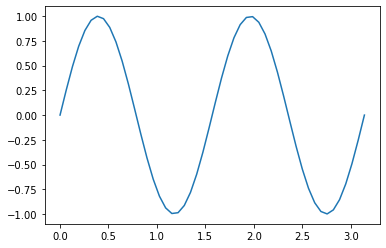

In [131]:
x=np.linspace(0,np.pi,50)[:,None]
y=np.sin(4*x)
plt.plot(x,y)

We approximate target func piece-wise by a series of segments. Each segment consists of a pair of neurons, each of which has a very large weight and thus acts as a step function. First neuron of the pair activates its step at the start of the segment. Second neuron zeroes the activation of the first by firing its step at the end of the segment with negated activation.

In [132]:
n=10 # number of segments
s=np.linspace(0,np.pi,n+1) # segments
# because neurons come in pairs, double the number of inner points
s=np.hstack([s[:1],
             np.broadcast_to(s[1:-1].reshape(-1,1),(len(s)-2,2)).reshape(-1),
             s[-1:]])
s.reshape((-1,2))

array([[0.        , 0.31415927],
       [0.31415927, 0.62831853],
       [0.62831853, 0.9424778 ],
       [0.9424778 , 1.25663706],
       [1.25663706, 1.57079633],
       [1.57079633, 1.88495559],
       [1.88495559, 2.19911486],
       [2.19911486, 2.51327412],
       [2.51327412, 2.82743339],
       [2.82743339, 3.14159265]])

When weight is large, sigmoid becomes a step. Step occurs at inflection point z=0, i.e. at z=wx+b=0 => at x=-b/w. So having a range of segments s where steps must occur and a weight w, our bias b=-ws.

/home/fil/miniconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


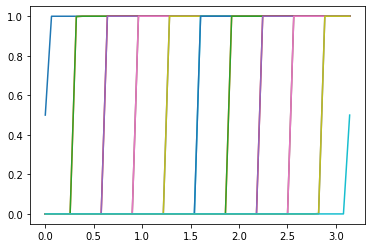

In [133]:
def sigmoid(z): return 1./(1.+np.exp(-z))
def dbg(**kws):
    if debug: [print(f'{k}:\n{v}') for k,v in kws.items()]

debug=False

w=1000. # large weight
b=-w*s
dbg(b=b)
z1=w*x+b
dbg(z1=z1)
a1=sigmoid(z1) # warning will show up because of overflow due to big weight
dbg(a1=a1)

plt.plot(x,a1); # plot all steps

Steps are unit height, so we just need to modulate them w/ our target func. For this we grab func values for each segment, then double them and make pairs of original value and negated. First neuron of a pair fires its step w/ original func value, second neuron eliminates the first by firing its step w/ negated value.

h:
[[ 0.00000000e+00 -0.00000000e+00]
 [ 9.58667853e-01 -9.58667853e-01]
 [ 5.45534901e-01 -5.45534901e-01]
 [-8.20172255e-01  8.20172255e-01]
 [-7.81831482e-01  7.81831482e-01]
 [ 5.98110530e-01 -5.98110530e-01]
 [ 9.38468422e-01 -9.38468422e-01]
 [-3.15108218e-01  3.15108218e-01]
 [-9.99486216e-01  9.99486216e-01]
 [-4.89858720e-16  4.89858720e-16]]


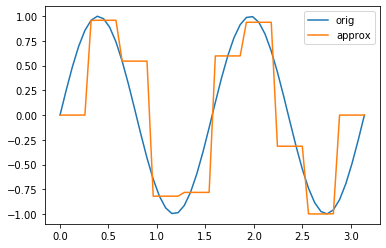

In [136]:
h=y[np.linspace(0,len(y)-1,n).astype(int)] # sample original func for each segment
# negate values and form pairs, essentially these are outgoing weights of the first layer
# in the single output neuron
h=np.hstack([h,-h]).reshape(-1)
print(f'h:\n{h.reshape((-1,2))}')
# modulate steps with func values, no sigmoid here, just a linear output neuron
z2=np.sum(a1*h,axis=1)
dbg(z2=z2)
plt.plot(x,y,label='orig')
plt.plot(x,z2,label='approx')
plt.legend()

### Let's see how well nn can approximate noise

In [288]:
# wrap all above into a func
def approx(x,y,n_seg,sortx=False,spreadx=False,w=1000.,debug=False):
    def dbg(**kws):
        if debug: [print(f'{k}:\n{v}') for k,v in kws.items()]

    dbg(x=x,y=y)
    if spreadx: sortx=True
    if sortx: # sort x's and y's in case it's noise
        i=np.argsort(x)
        x,y=x[i],y[i]
        dbg(i=i,sorted_x=x,sorted_y=y)
    if spreadx:
        x_orig=x # x will non-reversibly changed, save original
        x=np.round_(np.linspace(x[0],x[-1],len(x)),2)
        dbg(spread_x=x)
    x,y=x[:,None],y[:,None]
        
    s=np.linspace(np.min(x),np.max(x),n_seg+1)
    s=np.hstack([s[:1],
                 np.broadcast_to(s[1:-1].reshape(-1,1),(len(s)-2,2)).reshape(-1),
                 s[-1:]])
    dbg(s=s.reshape((-1,2)))
    b=-w*s
    z1=w*x+b
    a1=sigmoid(z1)
    plt.plot(x,a1)
    plt.show()

    h=y[np.linspace(0,len(y)-1,n_seg).astype(int)]
    h=np.hstack([h,-h]).reshape(-1)
    z2=np.sum(a1*h,axis=1)
    plt.plot(x,y,'x-',label='orig')
    plt.plot(x,z2,label='approx')
    if spreadx:
        plt.plot(x_orig,y,'o-',label='orig, no spread')
    plt.legend()

With noise as is everything is scrambled due to x being unsorted. In this case y is not even a function.

/home/fil/miniconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


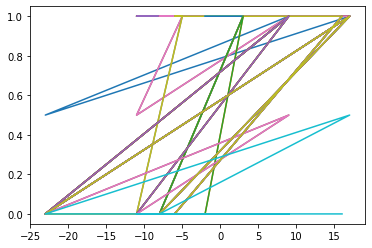

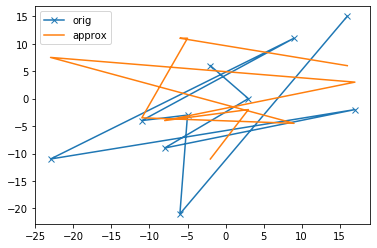

In [273]:
np.random.seed(1)
approx(*np.rint(np.random.randn(2,10)*10),10)

With x sorted things get better, but due to uneven spread of x's step functions are mostly broken. We can say than y is kinda not very continuous.

/home/fil/miniconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


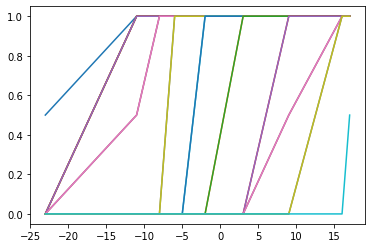

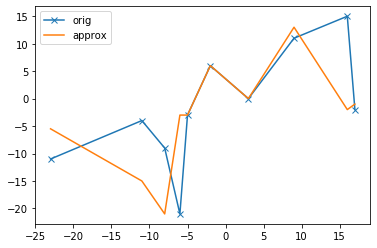

In [274]:
np.random.seed(1)
approx(*np.rint(np.random.randn(2,10)*10),10,sortx=True)

When noise x is sorted and spread evenly y becomes pretty much as any other func and is approximated well. But spreading x essentially gives the func that is different from original, as seen below.

/home/fil/miniconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


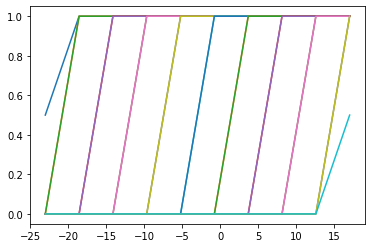

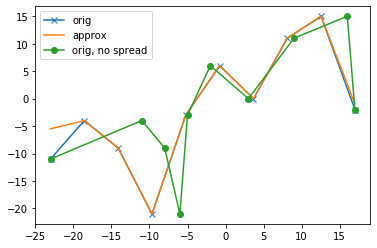

In [290]:
np.random.seed(1)
approx(*np.rint(np.random.randn(2,10)*10),10,spreadx=True)

### ReLU

My proof of universality w/ relu is as folows. You can't make a step func w/ a single relu. So you take 2 relus w/ second doing cutoff a bit further on x axis than first. In these relus weight is not important, just bias, which specifies where on x axis they lie. 3rd relu then calculates diff between output of 1st and 2nd thus creating a kind of step func. The diff is scaled so it reaches 1. at the highest point. The closer relu 1 and 2 are placed, the steeper step func becomes.

After having unit step func we can build a bump w/ 3 more relus and so on like w/ sigmoid above.

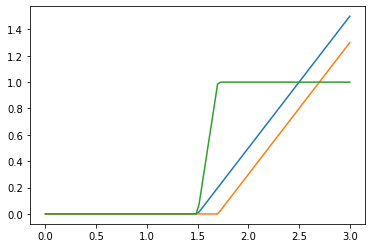

In [415]:
x=np.linspace(0,3,100)
s=1.5 # x value where step occurs
ds=.2 # interval between relu 1 and 2, smaller is steeper

z1=x-s
a1=np.maximum(z1,0)
z2=x-(s+ds)
a2=np.maximum(z2,0)

w=1/ds
z=w*(a1-a2)
a=np.maximum(z,0)

plt.plot(x,a1)
plt.plot(x,a2)
plt.plot(x,a)